In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [7]:
zoo = pd.read_csv('data/zoo.csv')
class_label = pd.read_csv('data/class.csv')

- First, we see that fot not every animal class we have the same number of rows. In this dataset, the less frequent type of animal are the amphibians, and the most common the mammals. This makes sense for a zoo, which contains a variety of different animals.

In [8]:
class_label

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


- As it is stated on the source page of the dataset, the zoo dataframe contains information about characteristics of each animal. Mostly of the features are of boolean type, except for _legs_ which is a numerical column. This is the dataset we will use to analyze information and to develop our model.

In [11]:
zoo

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


# Analysis

## EDA

- First, let's see the presence of each of the variables in the dataset.
- Since the majority of these features are boolean (legs is numerical, and class_type is the label to verify our results), computing the mean is equivalent to the percentage of rows that are true for that feature.

In [17]:
zoo.describe().loc['mean']

hair          0.425743
feathers      0.198020
eggs          0.584158
milk          0.405941
airborne      0.237624
aquatic       0.356436
predator      0.554455
toothed       0.603960
backbone      0.821782
breathes      0.792079
venomous      0.079208
fins          0.168317
legs          2.841584
tail          0.742574
domestic      0.128713
catsize       0.435644
class_type    2.831683
Name: mean, dtype: float64

,index,mean
0,hair,0.425743
1,feathers,0.198020
2,eggs,0.584158
3,milk,0.405941
4,airborne,0.237624
5,aquatic,0.356436
6,predator,0.554455
7,toothed,0.603960
8,backbone,0.821782
9,breathes,0.792079


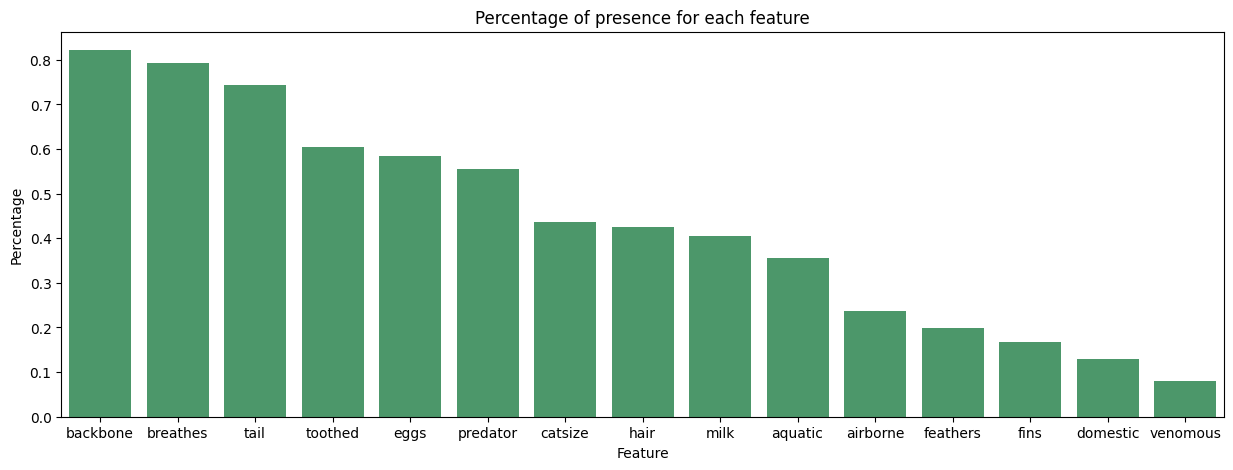

In [28]:
plt.figure( figsize = (15,5))

ax = sns.barplot(data = zoo.describe().loc['mean'].drop(['legs', 'class_type']).sort_values(ascending = False),
                 color = sns.xkcd_rgb['greenish'])

ax.set_title('Percentage of presence for each feature')
ax.set_xlabel('Feature')
ax.set_ylabel('Percentage')

plt.show()